In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic
from enum import Enum
from typing import Any, List

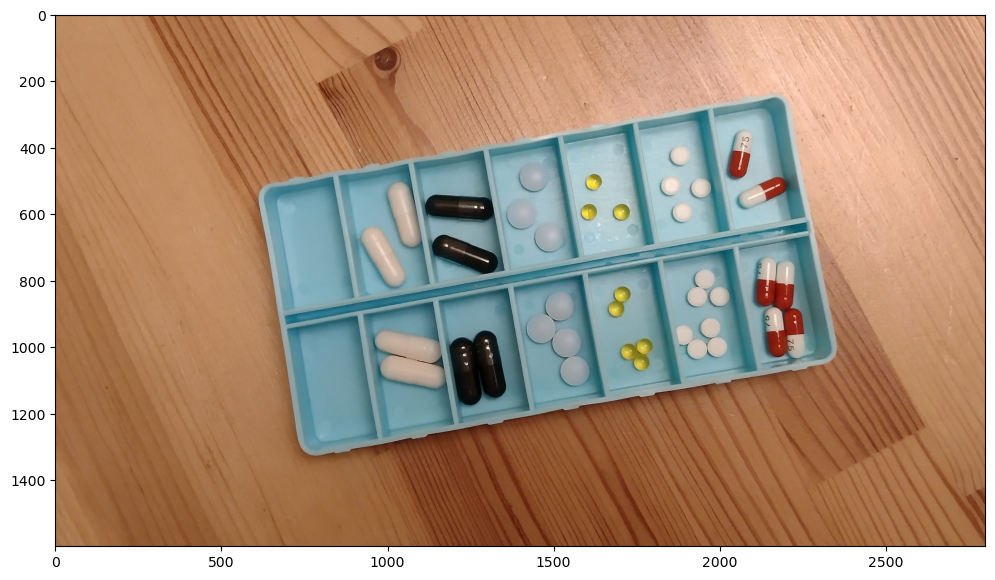

In [191]:
calib = cv2.imread('calib.png')
test = cv2.imread('test.png')
test_line = cv2.imread('test_line.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

In [143]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)
    
"""COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (0, 0, 0),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}"""

COLORMAP = {
    # RGB colorspace
    1: (255, 255, 255),
    2: (100, 100, 100),
    3: (0, 0, 255),
    4: (255, 255, 0),
    5: (255, 0, 255),
    6: (255, 0, 0),
}

In [107]:
COLORMAP[PillType.PROBIO]

(255, 255, 255)

In [4]:
class Pill:
    """Output of object detection, represents a single instance"""
    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location
        
    def __str__(self) -> str:
        return str(self.type)

## BASIC

In [5]:
def gray(img, show=False):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if show:
        plt.imshow(img_gray, cmap='gray')  # cmap='gray' for grayscale images
        plt.title('Otsu Thresholded Image')
        plt.axis('off')  # Optional: Turn off axis labels
        plt.show()
        
    return img_gray

In [6]:
def blur(image, size, show=False, color=False):
    img_blurred = cv2.GaussianBlur(image, (size, size), 0)
    if show:
        if color:
            img_to_show = cv2.cvtColor(img_blurred, cv2.COLOR_BGR2RGB)
        else:
            img_to_show = img_blurred
        plt.imshow(img_to_show)  # cmap='gray' for grayscale images
        plt.title('Otsu Thresholded Image')
        plt.axis('off')  # Optional: Turn off axis labels
        plt.show()
    return img_blurred

## OTSU

In [7]:
def otsu(window_size, image_gray, step=False, show=False, reverse=False):

    if step:
        pass
    else:
        step = window_size
        

    height, width = image_gray.shape
    binary_result = np.zeros((height, width), dtype=np.uint8)

    for y in range(0, height, step):
        for x in range(0, width, step):
            window = image_gray[y:y+window_size, x:x+window_size]
            otsu_threshold, window_result = cv2.threshold(window, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            binary_result[y:y+window_size, x:x+window_size] = window_result
            
    if reverse:
        binary_result = cv2.bitwise_not(binary_result)
    if show:
        plt.imshow(binary_result, cmap='gray')  # cmap='gray' for grayscale images
        plt.title('Otsu Thresholded Image')
        plt.show()
    
    return binary_result

## CUT

In [8]:
def cut(img, low_bound, hight_bound, color=[255, 255, 255], show=False):

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Stwórz maskę dla koloru czerwonego
    red_mask = cv2.inRange(img_hsv, low_bound, hight_bound)
    img_cut = img.copy()
    #img_cut = cv2.bitwise_and(img, img, mask=~red_mask)
    img_cut[red_mask != 0] = color
    if show:
        img_to_show = cv2.cvtColor(img_cut, cv2.COLOR_BGR2RGB)
        plt.imshow(img_to_show)  # cmap='gray' for grayscale images
        plt.title('Otsu Thresholded Image')
        #plt.axis('off')  # Optional: Turn off axis labels
        plt.show()
            
    return img_cut

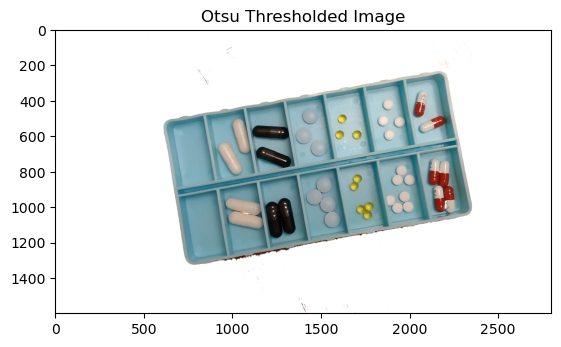

In [9]:
# brązowe
def remove_floor(img, show=False):
    lower_brown = np.array([6,70, 90])
    upper_brown = np.array([19, 255, 255])
    box = cut(img, lower_brown, upper_brown, show=show)
    return box
box = remove_floor(calib, show=True)

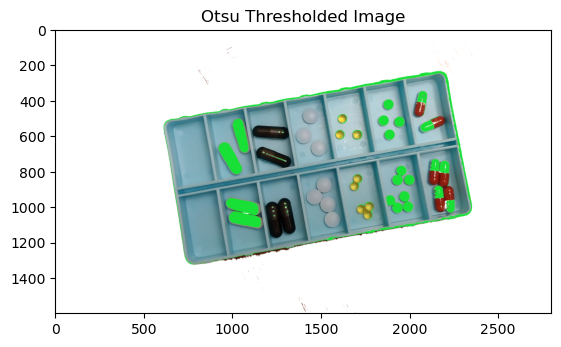

In [10]:
colors_map = {'white': [54,224,24]}
def color_white(img, show=False):
    lower_white = np.array([0,0, 150])
    upper_white = np.array([80, 70, 254])
    box_green = cut(img, lower_white, upper_white, color=colors_map['white'], show=False)
    lower_white = np.array([145,0, 160])
    upper_white = np.array([180, 70, 254])
    box_green = cut(box_green, lower_white, upper_white, color=colors_map['white'], show=show)
    return box_green

box_green = color_white(box, show=True)

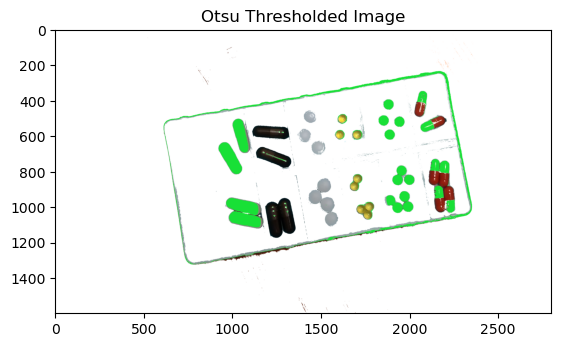

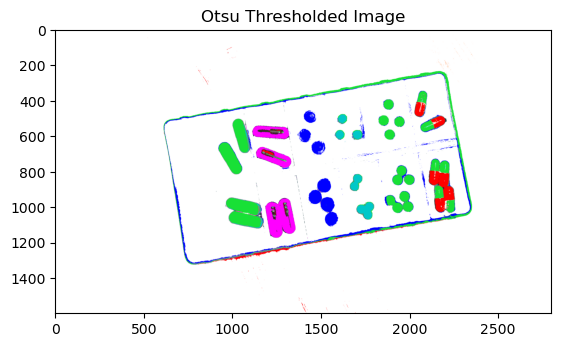

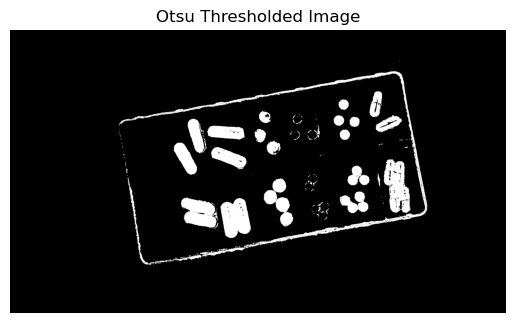

In [38]:
#pudełkowe
def remove_box(img, show=False):
    lower_blue = np.array([80,40, 90])
    upper_blue = np.array([140, 255, 255])
    pills = cut(img, lower_blue, upper_blue, color=[255,255,255], show=False)
    lower_blue = np.array([80,30, 180])
    upper_blue = np.array([140, 255, 255])
    pills = cut(pills, lower_blue, upper_blue, color=[255,255,255], show=False)
    lower_blue = np.array([80,20, 195])
    upper_blue = np.array([160, 255, 240])
    pills = cut(pills, lower_blue, upper_blue, color=[255,255,255], show=False)
    lower_blue = np.array([90,20, 180])
    upper_blue = np.array([100, 50, 190])
    pills = cut(pills, lower_blue, upper_blue, color=[255,255,255], show=False)
    lower_blue = np.array([80,35, 70])
    upper_blue = np.array([160, 255, 180])
    pills = cut(pills, lower_blue, upper_blue, color=[255,255,255], show=show)
    return pills

pills = remove_box(box_green, show=True)



colors_map.update({
    'grey': [255,0,0],
    'black':[255,0,255],
    'yellow_edge': [255,255,0],
    'yellow': [200,200,0],
    'red': [0,0,255]
})

#szare
def color_pills(img, show=False):
    lower_blue = np.array(object=[80,0, 150])
    upper_blue = np.array([140, 60, 200])
    pills = cut(img, lower_blue, upper_blue, color=colors_map['grey'], show=False)

#czarne
    lower_blue = np.array([0,0, 0])
    upper_blue = np.array([180, 255, 40])
    pills = cut(pills, lower_blue, upper_blue, color=colors_map['black'], show=False)

# zółte
    lower_blue = np.array([20,0, 0])
    upper_blue = np.array([38, 200, 200])
    pills = cut(pills, lower_blue, upper_blue, color=colors_map['yellow_edge'], show=False)

#oblicz sharp
    yellow_sharp, _ = sharp(pills, show=False)
    yellow_sharp_bin = otsu(2000, gray(yellow_sharp, 
                                       False), show=False, reverse=True)
    yellow_edges = morph(yellow_sharp_bin, get_cross(4), show=False)
    mask = np.all(pills == colors_map['yellow_edge'], axis=-1)
    pills[mask] = colors_map['yellow']
# zółte
    lower_blue = np.array([20,0, 40])
    upper_blue = np.array([38, 255, 255])
    pills = cut(pills, lower_blue, upper_blue, color=colors_map['yellow'], show=False)

# czerwone
    lower_blue = np.array([1,100, 50])
    upper_blue = np.array([15, 255, 255])
    pills = cut(pills, lower_blue, upper_blue, color=colors_map['red'], show=show)
    return pills, yellow_edges

pills, abc = color_pills(pills, show=True)

plt.imshow(abc, cmap='gray')  # cmap='gray' for grayscale images
plt.title('Otsu Thresholded Image')
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

[ 28 169 118]


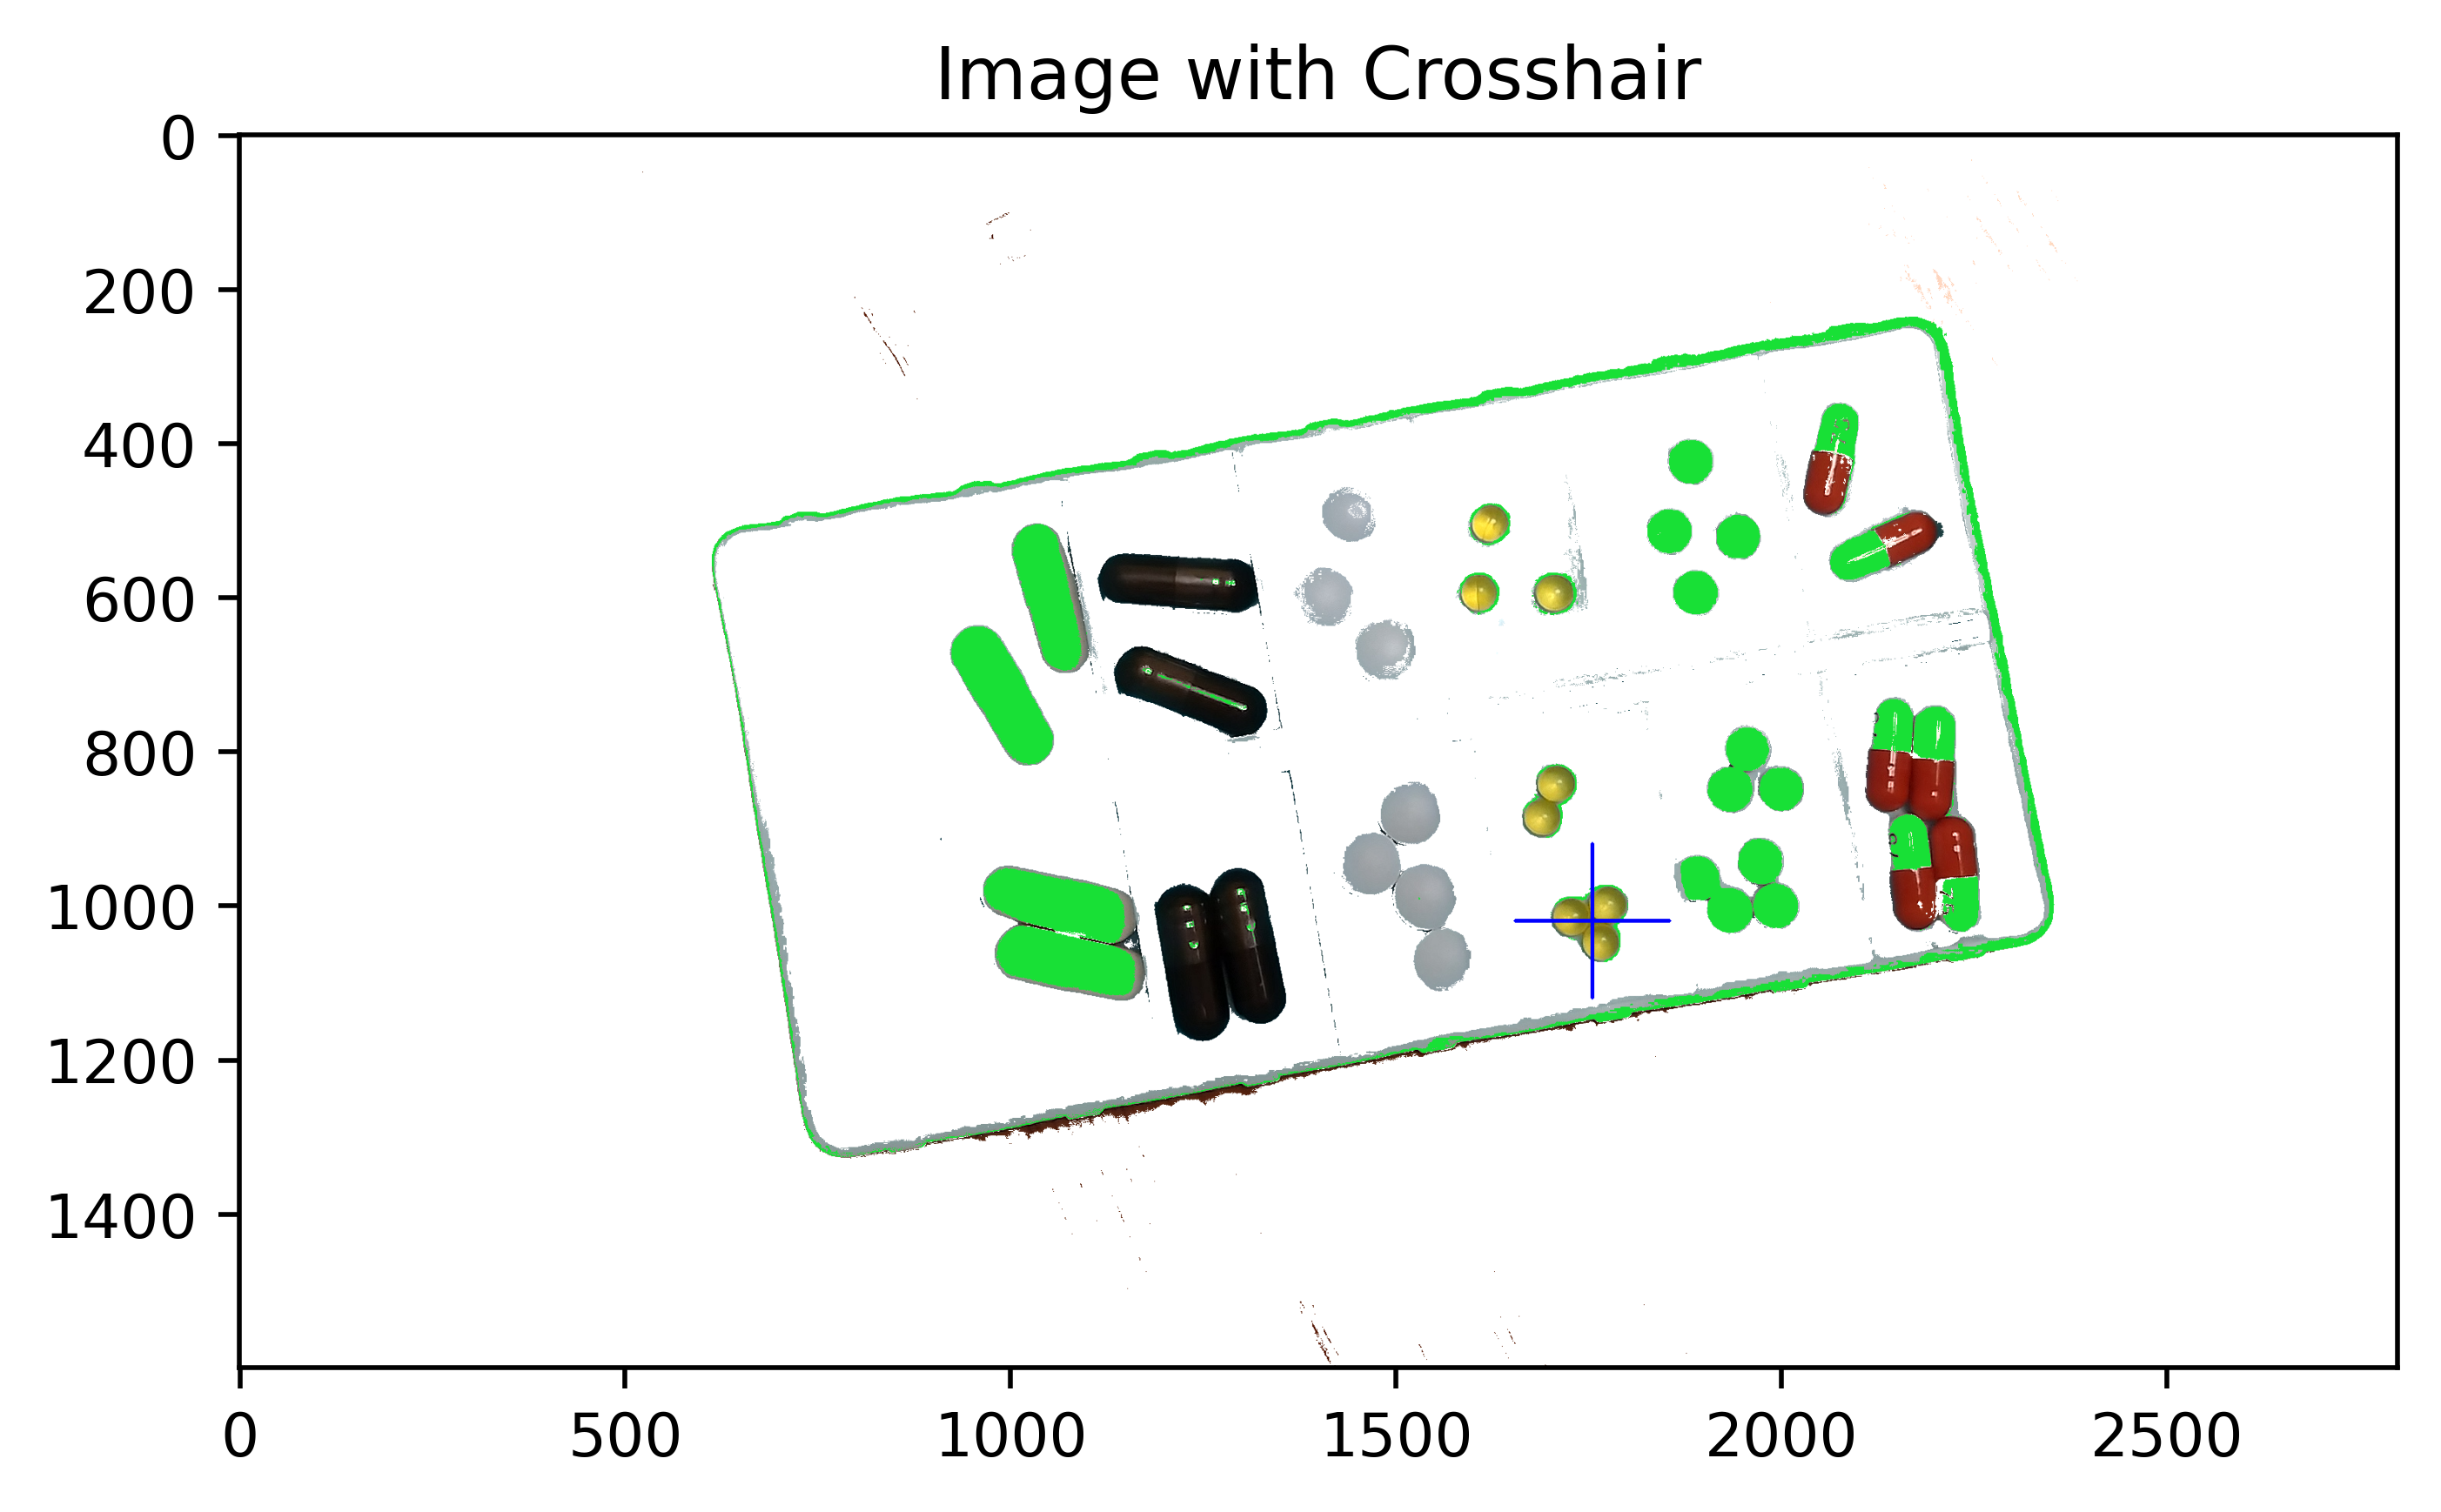

In [13]:
def add_crosshair(img, pixel_coordinates):
    # Wczytaj obraz

    # Dodaj krzyżyk na zadanym pikselu
    img_with_crosshair = img.copy()
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    print(img_hsv[pixel_coordinates[1], pixel_coordinates[0]])
    img_with_crosshair = cv2.cvtColor(img_with_crosshair, cv2.COLOR_BGR2RGB)
    img_with_crosshair = cv2.drawMarker(img_with_crosshair, 
                                        tuple(pixel_coordinates), 
                                        color=(0, 0, 255), 
                                        markerType=cv2.MARKER_CROSS, 
                                        markerSize=200, thickness=3)
    
    # Wyświetl obraz z krzyżykiem
    plt.imshow(img_with_crosshair)
    plt.title('Image with Crosshair')
    plt.show()
plt.rcParams['figure.dpi'] = 500
boxy = [1750,600]
pilla = [1755, 1020]
add_crosshair(pills, pilla)
plt.rcParams['figure.dpi'] = 100

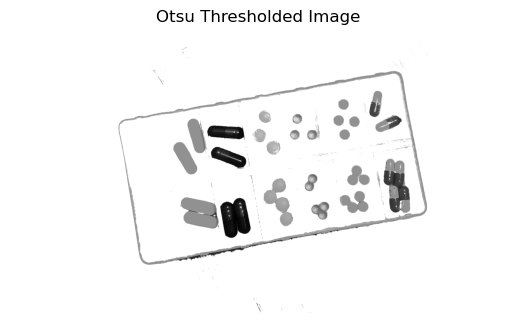

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [14]:
gray(pills, True)

## SHARP

In [15]:
def sharp(img, show=False):
    # Create a kernel that we will use to sharpen our image
    # an approximation of second derivative, a quite strong kernel
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
    # do the laplacian filtering as it is
    # well, we need to convert everything in something more deeper then CV_8U
    # because the kernel has some negative values,
    # and we can expect in general to have a Laplacian image with negative values
    # BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
    # so the possible negative number will be truncated
    imgLaplacian = cv2.filter2D(img, cv2.CV_32F, kernel)
    sharp = np.float32(img)
    imgResult = sharp - imgLaplacian
    # convert back to 8bits gray scale
    imgResult = np.clip(imgResult, 0, 255)
    imgResult = imgResult.astype('uint8')
    imgLaplacian = np.clip(imgLaplacian, 0, 255)
    imgLaplacian = np.uint8(imgLaplacian)
    #cv.imshow('Laplace Filtered Image', imgLaplacian)
    if show:
        img_to_show = cv2.cvtColor(imgResult, cv2.COLOR_BGR2RGB)
        plt.imshow(imgLaplacian)
        plt.show()
        plt.imshow(img_to_show)  # cmap='gray' for grayscale images
        plt.title('Otsu Thresholded Image')
        plt.axis('off')  # Optional: Turn off axis labels
        plt.show()
        
    return imgResult, imgLaplacian


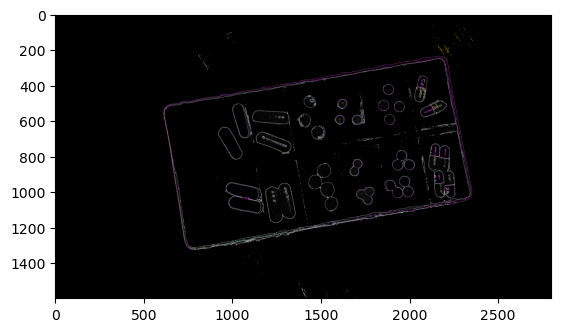

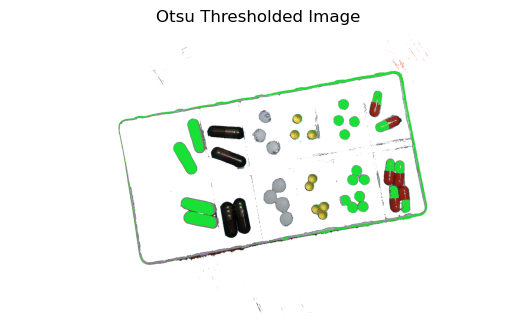

In [16]:
box_sharp, _ = sharp(pills, show=True)

## Binarize

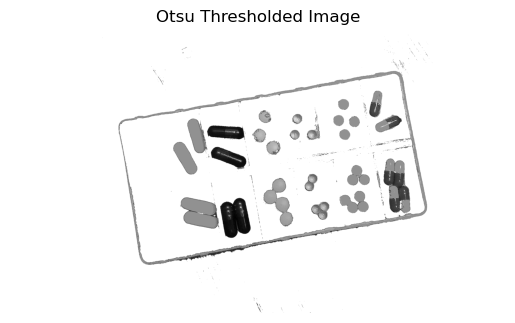

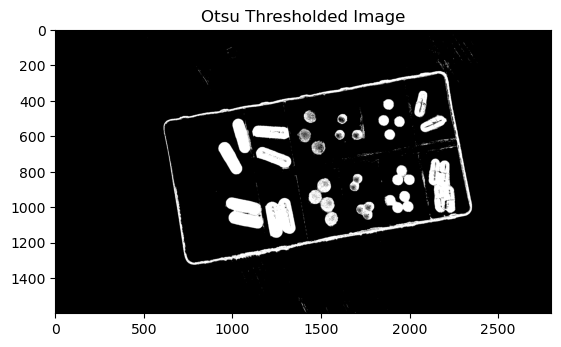

In [17]:
box_bin = otsu(2000, gray(box_sharp, True), show=True, reverse=True)

## Morph

In [18]:
def get_kernel(size):
    return cv2.getStructuringElement(cv2.MORPH_RECT, (size,size))

def get_cross(size):
    return cv2.getStructuringElement(cv2.MORPH_CROSS, (size,size))

def morph(img, kernel, open=True, show=False):
    if open:
        new_img = cv2.morphologyEx(img, op=cv2.MORPH_OPEN, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    else:
        new_img = cv2.morphologyEx(img, op=cv2.MORPH_CLOSE, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)

    if show:
        #img_to_show = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
        plt.imshow(new_img)  # cmap='gray' for grayscale images
        plt.title('Otsu Thresholded Image')
        plt.axis('off')  # Optional: Turn off axis labels
        plt.show()
    return new_img

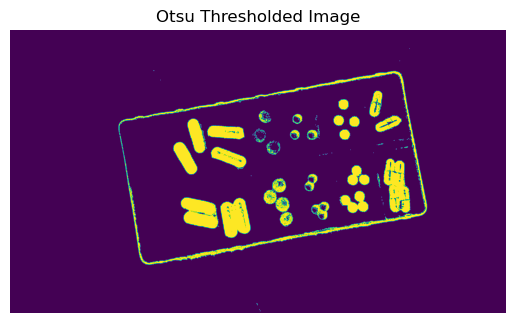

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [19]:
morph(box_bin, get_cross(3), show=True)

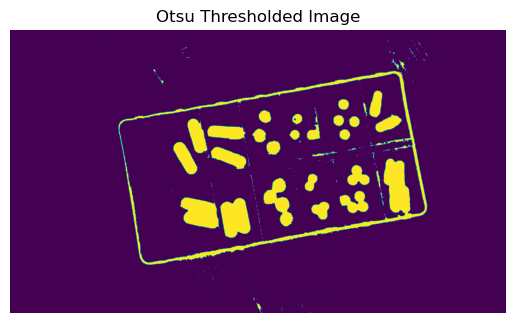

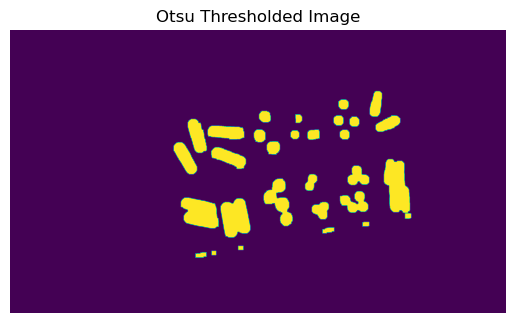

"kernel = get_cross(3)\nbbbb = cv2.erode(img_morph, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=15)\nplt.imshow(bbbb)  # cmap='gray' for grayscale images\nplt.title('Otsu Thresholded Image')\nplt.axis('off')  # Optional: Turn off axis labels\nplt.show()"

In [20]:
img_morph = morph(box_bin, get_kernel(9), open=False, show=True)
img_morph = morph(img_morph, get_kernel(23), open=True, show=True)
"""kernel = get_cross(3)
bbbb = cv2.erode(img_morph, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=15)
plt.imshow(bbbb)  # cmap='gray' for grayscale images
plt.title('Otsu Thresholded Image')
plt.axis('off')  # Optional: Turn off axis labels
plt.show()"""
#img_morph = morph(img_morph, get_kernel(17), open=True, show=True)
#img_morph = morph(img_morph, get_kernel(9), open=True, show=True)
#img_morph = morph(img_morph, get_kernel(9), open=True, show=True)
#img_morph = morph(img_morph, get_kernel(50), open=True, show=True)



## FIND

In [21]:
def find(img, src_binary, show=False):
    contours, hierarchy = cv2.findContours(src_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if c.shape[0] > 3]
    contours = [c for c in contours if cv2.contourArea(c) < 70000 and cv2.contourArea(c) > 2000] # odsiewamy kontury po polu powierzchni

    filled_contours = []
    for contour in contours:
        display = np.zeros_like(img)
        cv2.drawContours(display, [contour], -1, (255, 255, 255), thickness=cv2.FILLED)
        filled_contours.append(np.copy(display))
        
    display = np.zeros_like(img)
    cv2.drawContours(display, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
     
    if show:
        plt.imshow(display)
    return display, contours, filled_contours

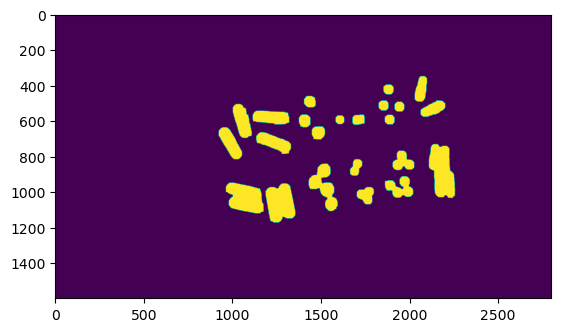

In [22]:
fillded_contoures, contours, _ = find(img_morph, img_morph, True)

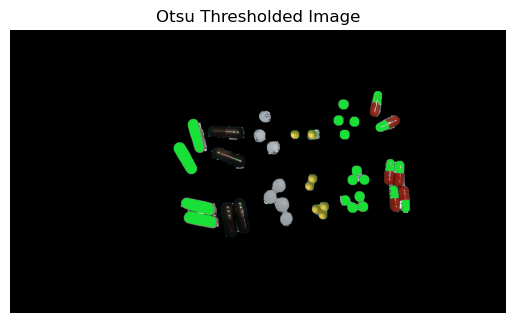

In [23]:
result = cv2.bitwise_and(box_sharp, box_sharp, mask=fillded_contoures)
img_to_show = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)  # cmap='gray' for grayscale images
plt.title('Otsu Thresholded Image')
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

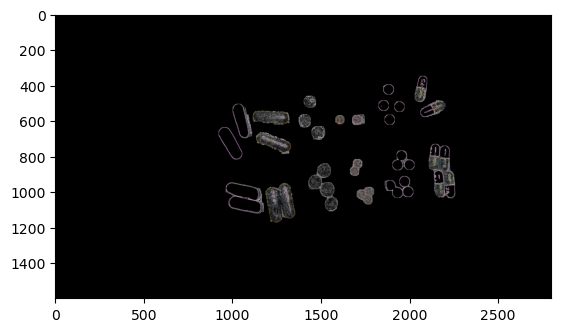

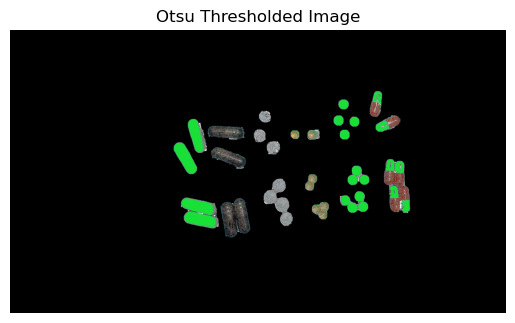

In [24]:
b= sharp(img=result, show=True)

## Distance


In [25]:
def distance(img, show=False):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dist = cv2.distanceTransform(img, cv2.DIST_L2, 5)
    # Normalize the distance image for range = {0.0, 1.0}
    # so we can visualize and threshold it
    cv2.normalize(dist, dist, 0.01, 1.0, cv2.NORM_MINMAX)
    if show:
        img_to_show = cv2.cvtColor(dist, cv2.COLOR_BGR2RGB)
        plt.imshow(img_to_show)  # cmap='gray' for grayscale images
        plt.title('Otsu Thresholded Image')
        plt.axis('off')  # Optional: Turn off axis labels
        plt.show()
        
    return dist

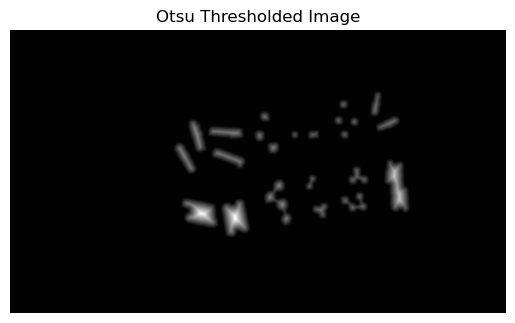

In [26]:
dist = distance(fillded_contoures, show=True)

In [27]:
def dilate(dist, show=False):
    #_, dist = cv2.threshold(dist, 0.001, 0.1, cv2.THRESH_BINARY)
    _, dist = cv2.threshold(dist, 0.3, 1.0, cv2.THRESH_BINARY)
    plt.imshow(dist)  # cmap='gray' for grayscale images
    plt.title('Otsu Thresholded Image')
    plt.axis('off')  # Optional: Turn off axis labels
    plt.show()
    # Dilate a bit the dist image
    kernel1 = get_cross(3)
    dist = cv2.erode(dist, kernel1, iterations=1)
    if show:
        img_to_show = cv2.cvtColor(dist, cv2.COLOR_BGR2RGB)
        plt.imshow(dist, cmap='gray')  # cmap='gray' for grayscale images
        plt.title('Otsu Thresholded Image')
        plt.axis('off')  # Optional: Turn off axis labels
        plt.show()

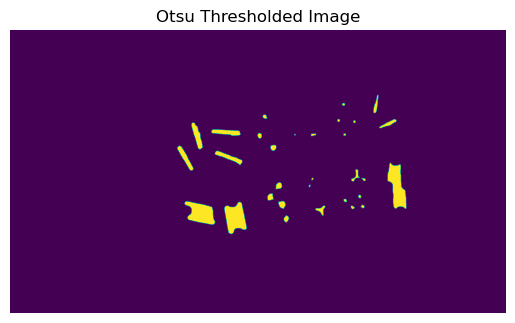

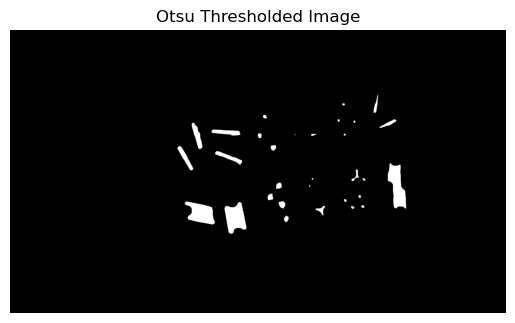

In [28]:
dist1 = dilate(dist, show=True)

## DETECT

In [116]:
def manipulate_img(img):
    img = remove_floor(img)
    img = color_white(img)
    img = remove_box(img)
    img, yellow_edges = color_pills(img)
    img, imgLaplacian = sharp(img)
    img_bin = otsu(2000, gray(img, False), 
                   show=False, reverse=True)
    img_bin = morph(img_bin, get_kernel(9),
                      open=False, show=False)
    img_bin = morph(img_bin, get_kernel(23), 
                      open=True, show=False)
    contours_img, contours, filled_contours = find(img_bin, 
                                                        img_bin, 
                                                        False)
    
    result = cv2.bitwise_and(img, img, mask=contours_img)
    
    for i in range(len(filled_contours)):
        filled_contours[i] = cv2.bitwise_and(img, img,
                                             mask=filled_contours[i])
    
    return img, result, contours, filled_contours, imgLaplacian, yellow_edges
    

In [117]:
def remove_lap(img1_path, img2_path, output_path):
    # Wczytaj obrazy
    img1 = np.array(Image.open(img1_path))
    img2 = np.array(Image.open(img2_path))

    # Utwórz maskę dla pikseli img2 różnych od [0,0,0]
    mask = np.any(img2 != [0, 0, 0], axis=-1)

    # Ustaw wartości pikseli img1 na [0,0,0] tam, gdzie maska jest prawdziwa
    img1[mask] = [0, 0, 0]

In [125]:
def detect_big_white(contour, filled_contour, imgLaplacian):
    big_green_pills = []
    colors_map['white']

    # usuń ostre miejsca
    mask = np.any(imgLaplacian != [0, 0, 0], axis=-1)
    filled_contour[mask] = [0, 0, 0]

    
    # znajdź kontury zielonych
    mask = np.all(filled_contour == colors_map['white'], axis=-1)
    big_green_contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, 
                                   cv2.CHAIN_APPROX_SIMPLE)
    display = np.zeros_like(filled_contour)
    cv2.drawContours(display, big_green_contours, -1, (255, 255, 255), 
                     thickness=cv2.FILLED)

    for i, big_green_contour in enumerate(big_green_contours):
        piksels_num = cv2.contourArea(big_green_contour)
        if piksels_num > 9000:
            filled_new_pill = np.zeros_like(imgLaplacian)
            cv2.drawContours(filled_new_pill, [big_green_contour], -1, 
                             COLORMAP[1], 
                             thickness=cv2.FILLED)
            big_green_pills.append(Pill(1, big_green_contour))
        
    return big_green_pills

In [126]:
def detect_black(contour, filled_contour, imgLaplacian):
    black_pills = []
    colors_map['black']
    # jeśli jest mało czarnych usuń
    mask = np.all(filled_contour == colors_map['black'], axis=-1)
    if np.sum(mask) < 1000:
        return []
    # usuń ostre miejsca
    mask = np.any(imgLaplacian != [0, 0, 0], axis=-1)
    filled_contour[mask] = [0, 0, 0]

    # znajdź przebłyski
    mask = np.all(filled_contour != colors_map['black'], 
                  axis=-1)
    mask = mask.astype(np.uint8) * 255
    # zwiększ przebłyski
    mask = cv2.morphologyEx(mask, op=cv2.MORPH_CLOSE, 
                            kernel=get_cross(3), 
                            anchor=(-1,-1), 
                            borderType=cv2.BORDER_REPLICATE, iterations=30)

    black_contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, 
                                   cv2.CHAIN_APPROX_SIMPLE)
    display = np.zeros_like(filled_contour)
    cv2.drawContours(display, black_contours, -1, (255, 255, 255), 
                     thickness=cv2.FILLED)

    
    for i, black_contour in enumerate(black_contours):
        piksels_num = cv2.contourArea(black_contour)
        if piksels_num > 50:
            filled_new_pill = np.zeros_like(imgLaplacian)
            cv2.drawContours(filled_new_pill, [black_contour], -1, 
                             COLORMAP[2], 
                             thickness=cv2.FILLED)
            black_pills.append(Pill(2, black_contour))

    return black_pills

In [127]:
def detect_grey(contour, filled_contour, imgLaplacian):
    grey_pills = []
    colors_map['grey']
    mask = np.all(filled_contour == colors_map['grey'], axis=-1)
    if np.sum(mask) < 200:
        return []
    
    # usuń ostre miejsca
    mask = np.any(imgLaplacian != [0, 0, 0], axis=-1)
    filled_contour[mask] = [0, 0, 0]

    # znajdź kontury szarych
    mask = np.all(filled_contour == colors_map['grey'], 
                  axis=-1)
    mask = mask.astype(np.uint8) * 255
    # zwiększ rodziel na pewno
    mask = cv2.erode(mask,  
                            kernel=get_cross(7), 
                            iterations=4)

    grey_contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, 
                                   cv2.CHAIN_APPROX_SIMPLE)
    display = np.zeros_like(filled_contour)
    cv2.drawContours(display, grey_contours, -1, (255, 255, 255), 
                     thickness=cv2.FILLED)

    
    for i, grey_contour in enumerate(grey_contours):
        piksels_num = cv2.contourArea(grey_contour)
        if piksels_num > 40 and piksels_num < 5000:
            filled_new_pill = np.zeros_like(imgLaplacian)
            cv2.drawContours(filled_new_pill, [grey_contour], -1, 
                             COLORMAP[3], 
                             thickness=cv2.FILLED)
            grey_pills.append(Pill(3, grey_contour))

    return grey_pills

In [128]:
def detect_yellow(contour, filled_contour, imgLaplacian, yellow_edges):
    _, yellow_edges = cv2.threshold(yellow_edges, 0, 1, cv2.THRESH_BINARY)
    yellow_pills = []
    colors_map['grey']
    mask = np.all(filled_contour == colors_map['yellow'], axis=-1)
    if np.sum(mask) < 50:
        return []
    
    # usuń ostre miejsca
    mask = np.any(imgLaplacian != [0, 0, 0], axis=-1)
    filled_contour[mask] = [0, 0, 0]
    

    # usuń ostre miejsca
    mask = yellow_edges == 1
    
    filled_contour[mask==1] = [0, 0, 0]

    # znajdź kontury szarych
    mask = np.all(filled_contour == colors_map['yellow'], 
                  axis=-1)
   
    mask = mask.astype(np.uint8) * 255
    # zwiększ rodziel na pewno
    
    mask = cv2.erode(mask, kernel=get_cross(3), iterations=5)
    
    yellow_contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, 
                                   cv2.CHAIN_APPROX_SIMPLE)
    display = np.zeros_like(filled_contour)
    cv2.drawContours(display, yellow_contours, -1, (255, 255, 255), 
                     thickness=cv2.FILLED)



    
    for i, yellow_contour in enumerate(yellow_contours):
        piksels_num = cv2.contourArea(yellow_contour)
        if piksels_num > 30 and piksels_num < 2000:
            filled_new_pill = np.zeros_like(imgLaplacian)
            cv2.drawContours(filled_new_pill, [yellow_contour], -1, 
                             COLORMAP[4], 
                             thickness=cv2.FILLED)
            yellow_pills.append(Pill(4, yellow_contour))

    return yellow_pills

In [186]:
def detect_small_white(contour, filled_contour, imgLaplacian, red_pills_num):
    small_white_pills = []
    colors_map['white']
    mask = np.all(filled_contour == colors_map['white'], axis=-1)
    if np.sum(mask) < 200:
        return []
    
    # usuń ostre miejsca
    mask = np.any(imgLaplacian != [0, 0, 0], axis=-1)
    filled_contour[mask] = [0, 0, 0]

    # znajdź kontury szarych
    mask = np.all(filled_contour == colors_map['white'], 
                  axis=-1)
    mask = mask.astype(np.uint8) * 255
    # zwiększ rodziel na pewno
    mask = cv2.erode(mask,  
                            kernel=get_cross(7), 
                            iterations=4)

    small_White_contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, 
                                   cv2.CHAIN_APPROX_SIMPLE)
    display = np.zeros_like(filled_contour)
    cv2.drawContours(display, small_White_contours, -1, (255, 255, 255), 
                     thickness=cv2.FILLED)

    counter = 0
    for i, small_White_contours in enumerate(small_White_contours):
        piksels_num = cv2.contourArea(small_White_contours)
        if piksels_num > 40 and piksels_num < 2000:
            if counter < red_pills_num:
                counter += 1
                continue
            filled_new_pill = np.zeros_like(imgLaplacian)
            cv2.drawContours(filled_new_pill, [small_White_contours], -1, 
                             COLORMAP[5], 
                             thickness=cv2.FILLED)
            small_white_pills.append(Pill(5, small_White_contours))

    return small_white_pills

In [187]:
def detect_red(contour, filled_contour, imgLaplacian):
    red_pills = []
    colors_map['red']
    mask = np.all(filled_contour == colors_map['red'], axis=-1)
    if np.sum(mask) < 200:
        return []

    
    # usuń ostre miejsca
    mask = np.any(imgLaplacian != [0, 0, 0], axis=-1)
    filled_contour[mask] = [0, 0, 0]

    """plt.imshow(filled_contour, cmap='gray')  # cmap='gray' for grayscale images
    plt.title('Otsu Thresholded Image')
    plt.axis('off')  # Optional: Turn off axis labels
    plt.show()"""
    # znajdź kontury szarych
    mask = np.all(filled_contour == colors_map['red'], 
                  axis=-1)
    mask = mask.astype(np.uint8) * 255
    # zwiększ rodziel na pewno
    mask = cv2.erode(mask,  
                            kernel=get_cross(3), 
                            iterations=10)

    mask = cv2.morphologyEx(mask, op=cv2.MORPH_CLOSE, 
                               kernel=get_kernel(2), anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    mask = cv2.dilate(mask,  
                        kernel=get_cross(3), 
                        iterations=1)
    mask = cv2.morphologyEx(mask, op=cv2.MORPH_CLOSE, 
                               kernel=get_kernel(2), anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    mask = cv2.dilate(mask,  
                        kernel=get_cross(3), 
                        iterations=1)
    """plt.imshow(mask, cmap='gray')  # cmap='gray' for grayscale images
    plt.title('Otsu Thresholded Image')
    plt.axis('off')  # Optional: Turn off axis labels
    plt.show()"""

    
    

    red_contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, 
                                   cv2.CHAIN_APPROX_SIMPLE)
    display = np.zeros_like(filled_contour)
    cv2.drawContours(display, red_contours, -1, (255, 255, 255), 
                     thickness=cv2.FILLED)

    
    for i, red_contour in enumerate(red_contours):
        piksels_num = cv2.contourArea(red_contour)
        if piksels_num > 200 and piksels_num < 4000:
            filled_new_pill = np.zeros_like(imgLaplacian)
            cv2.drawContours(filled_new_pill, [red_contour], -1, 
                             COLORMAP[6], 
                             thickness=cv2.FILLED)
            red_pills.append(Pill(6, red_contour))

    return red_pills

In [190]:
def detect_objects(image: np.ndarray, **kwargs) -> List[Pill]:
    img, img_manipulated, contours, filled_contours, imgLaplacian, yellow_edges = manipulate_img(image)
    all_pills = []
    """plt.imshow(filled_contours[7], cmap='gray')  # cmap='gray' for grayscale images
    plt.title('Otsu Thresholded Image')
    plt.axis('off')  # Optional: Turn off axis labels
    plt.show()
    return"""
    """print(len(contours))
    print(len(filled_contours))
        
    plt.imshow(img_manipulated)  # cmap='gray' for grayscale images
    plt.title('Otsu Thresholded Image')
    plt.axis('off')  # Optional: Turn off axis labels
    plt.show()"""
    
    for i in range(len(contours)):
        
        
        #print(len(red_pills))
        """plt.imshow(filled_contours[23], cmap='gray')  # cmap='gray' for grayscale images
        plt.title('Otsu Thresholded Image')
        plt.axis('off')  # Optional: Turn off axis labels
        plt.show()"""
        #break
        big_white_pills = detect_big_white(contours[i], filled_contours[i], 
                        imgLaplacian)
        black_pills = detect_black(contours[i], filled_contours[i], 
                             imgLaplacian)
        blue_pills = detect_grey(contours[i], filled_contours[i], 
                            imgLaplacian)
        yellow_pills = detect_yellow(contours[i], filled_contours[i], 
                            imgLaplacian, yellow_edges)
        red_pills = detect_red(contours[i], filled_contours[i], 
                            imgLaplacian)
        small_white_pills = detect_small_white(contours[i], filled_contours[i], 
                            imgLaplacian, len(red_pills))
        new_pills = big_white_pills + black_pills + blue_pills + yellow_pills + small_white_pills + red_pills
        """print(i)
        print([x.type for x in new_pills])
        plt.imshow(filled_contours[i])  # cmap='gray' for grayscale images
        plt.title('Otsu Thresholded Image')
        plt.axis('off')  # Optional: Turn off axis labels
        plt.show()
        display = np.zeros_like(img)
        cv2.drawContours(display, [contours[i]], -1, (255, 255, 255), 
                            thickness=cv2.FILLED)
        plt.imshow(display)  # cmap='gray' for grayscale images
        plt.title('Otsu Thresholded Image')
        plt.axis('off')  # Optional: Turn off axis labels
        plt.show()"""
        
        all_pills += new_pills
            
    
    
    return all_pills
        
objects = detect_objects(calib)

In [ ]:
import cv2
import numpy as np

# Kolor w formie RGB
rgb_color = np.array([200, 200, 0], dtype=np.uint8)

# Konwersja z RGB do HSV
hsv_color = cv2.cvtColor(np.uint8([[rgb_color]]), cv2.COLOR_RGB2HSV)[0][0]

print(f'HSV: {hsv_color}')

RGB: [200 200   0]
HSV: [ 30 255 200]


In [141]:


def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    # TU BĘDZIE TWOJA IMPLEMENTACJA METODY WIZUALIZACJI
    image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)  # cmap='gray' for grayscale images
    plt.title('Otsu Thresholded Image')
    plt.axis('off')  # Optional: Turn off axis labels
    plt.show()
    display = np.zeros_like(image)
    for object in objects:
        
        object_location = object.location
        cv2.drawContours(display, [object_location], -1, 
                             COLORMAP[object.type], 
                             thickness=cv2.FILLED)
        
    plt.imshow(display)

In [146]:
len(found)

42

In [195]:
found = detect_objects(calib)
display_objects(calib, found)

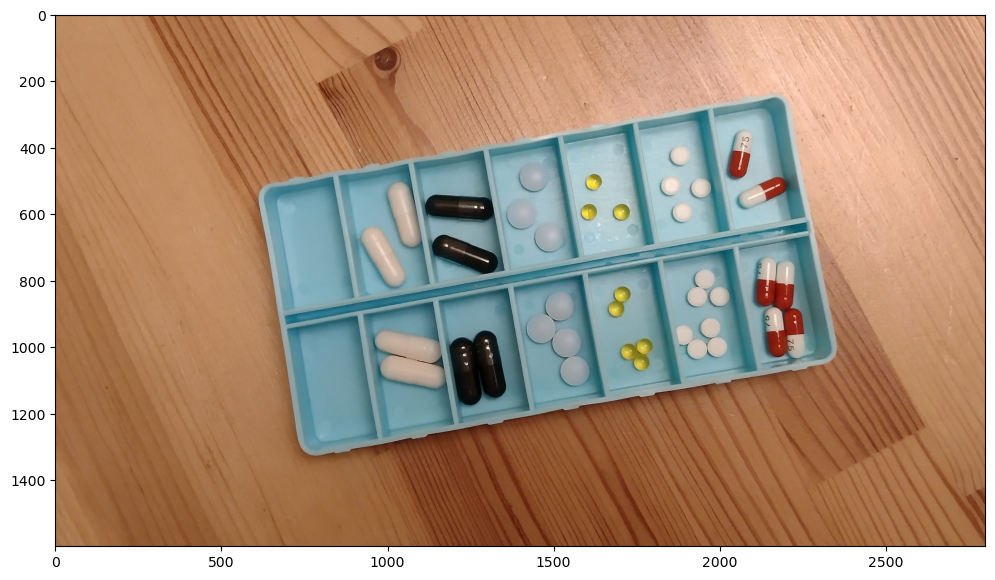

In [ ]:
calib_copy = calib.copy()
calib_copy[np.all(calib_copy == 255, axis=2)] = 0
# Show output image
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib_copy[..., ::-1]);

### Test